In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

df = pd.read_pickle('./food_data_cleaned.pkl')

# E. Time-series data
## Heatmap hour vs month
Your task is to investigate the total number of items created each month at each hour. You should use the created_at column to draw a heatmap with the hours (0 to 23) on the x-axis and the months (1 to 12) on the y-axis. The color of the heatmap should show the number of items created at each month-hour pair.

We define a new dataframe to start working on this part.

In [2]:
df_time = df.copy()

We have already converted created_at to datetime, so we can extract month and hour easily

In [3]:
df_time['month'] = df_time['created_at'].dt.month
df_time['hour'] = df_time['created_at'].dt.hour

In [4]:
df_time.loc[:,('created_at','month','hour')].sample(5)

,created_at,month,hour
id,,,
328668,2021-04-26 10:22:18.450000+00:00,4,10
259124,2021-04-26 10:21:41.170000+00:00,4,10
172374,2021-04-26 10:20:45.608000+00:00,4,10
224881,2021-04-26 10:21:20.510000+00:00,4,10
152842,2021-04-26 10:20:34.516000+00:00,4,10


Month and hour are properly extracted from timestamp

In [5]:
heatmap_month_hour = df_time.pivot_table(index='hour',columns='month', values='id', aggfunc='count')
heatmap_month_hour = heatmap_month_hour.dropna().astype(int)

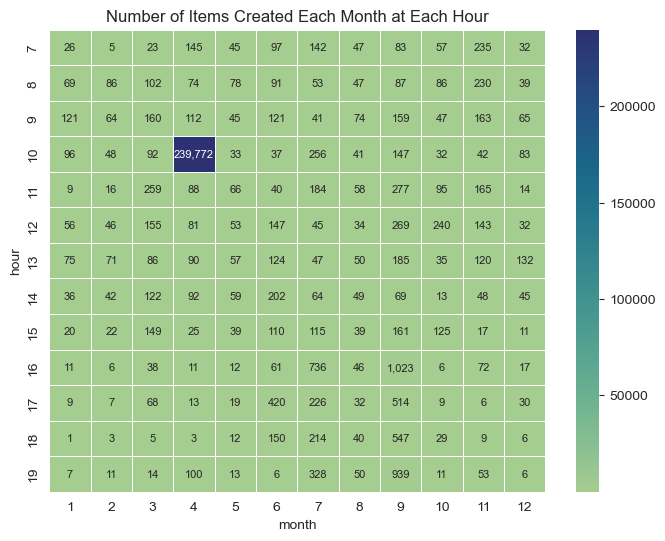

In [6]:
fig, axes = plt.subplots(figsize=(8, 6))
sns.heatmap(heatmap_month_hour,
            annot=True,
            annot_kws={'fontsize':8},
            fmt=',',
            linewidth=.5,
            cmap='crest')

plt.title('Number of Items Created Each Month at Each Hour')
plt.show()

We see that vast majority of records are suspiciously created at 10am during month of April. We will see in bar chart with month and year if that matches a specific month of april and a specific country. This would probably signify a one time upload of 240k products into platform foodrepo.

## Monthly volumes
Your task is to investigate the evolution of the total number of items over time. You should draw a bar plot with the date (e.g., in yyyy-mm format) on the x-axis and the total number of items created during each month on the y-axis. Each bar in the plot should stack the number of items created by each country each month. Please make sure all bars are visible by choosing the appropriate scale for the y-axis.

In [15]:
# This converts created_at to a period
# We first remove timezone information, as dt.to_period returns an error if ran with timezone
df_time['created_at'] = df_time['created_at'].dt.tz_localize(None)
# Converting into yyyy-mm format
df_time['creation_month'] = df_time['created_at'].dt.to_period('M')

# We create a pivot table for plotting, with country as we will need it for color.
timeline = df_time.pivot_table(index='creation_month', columns='country', values='id', aggfunc='count')

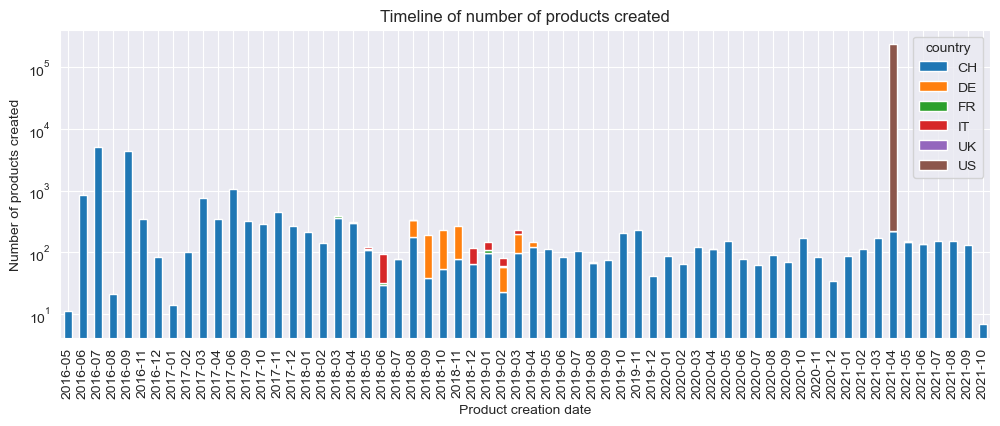

In [8]:
timeline.plot(kind='bar',
                   figsize=(12, 4),
                   stacked=True)
plt.title('Timeline of number of products created')  
plt.xlabel('Product creation date')
plt.ylabel('Number of products created')
plt.yscale('log')

Our guesstimate was correct, there was a one time upload on april 2021 at 10am for products in the US.

# F. Correlation analysis
## Quantitative (energy)
Your task is to quantify the linear relationships between the energy_per_hundred and other numerical variables. Use the per_hundred columns and find their correlations with energy_per_hundred.

In [9]:
# Select per_hundred_columns
per_hundred_columns = [column for column in df.columns if column.endswith('_per_hundred')]

# Calculate the correlation between 'energy_per_hundred' and all per_hundred columms.
correlations = df[per_hundred_columns].corr()['energy_per_hundred'].sort_values()
correlations

vitamin_d_d2_d3_international_units_per_hundred   -0.110704
vitamin_a_iu_per_hundred                          -0.098111
vitamin_c_ascorbic_acid_per_hundred               -0.078703
fatty_acids_total_trans_per_hundred                0.056825
cholesterol_per_hundred                            0.098772
sodium_per_hundred                                 0.102094
calcium_per_hundred                                0.178753
potassium_k_per_hundred                            0.195683
iron_per_hundred                                   0.242287
fiber_per_hundred                                  0.288638
protein_per_hundred                                0.353103
polyunsaturated_fatty_acids_per_hundred            0.428386
sugars_per_hundred                                 0.463557
monounsaturated_fatty_acids_per_hundred            0.481277
sugars_added_per_hundred                           0.522267
fatty_acids_total_saturated_per_hundred            0.564827
fat_per_hundred                         

## Linear or non-linear
Your task is to reveal the true nature of the relationship, linear or non-linear, between variables, using visualizations. Based on the correlation coefficients you found in the previous task, pick the three most correlated and the three least correlated variables (in absolute terms) with the energy_per_hundred column. Plot them against the energy_per_hundred column, using scatterplots. You should obtain these plots as subplots (with 2 rows and 3 columns) or seaborn pairplots.
Please comment on the visual relationships in a markdown cell. Are they all linear? Are there still extreme values that, once removed, relationships would change?

In [10]:
# Removing "energy columns"
correlations = correlations[~correlations.index.str.contains('energy')]
    
# Get the top and bottom 3 correlations based on absolute value
top_correlations_columns = list(correlations.abs().nlargest(3).index)
bottom_correlations_columns = list(correlations.abs().nsmallest(3).index)

correlations_columns = top_correlations_columns + bottom_correlations_columns
correlations_columns

['carbohydrates_per_hundred',
 'fat_per_hundred',
 'fatty_acids_total_saturated_per_hundred',
 'fatty_acids_total_trans_per_hundred',
 'vitamin_c_ascorbic_acid_per_hundred',
 'vitamin_a_iu_per_hundred']

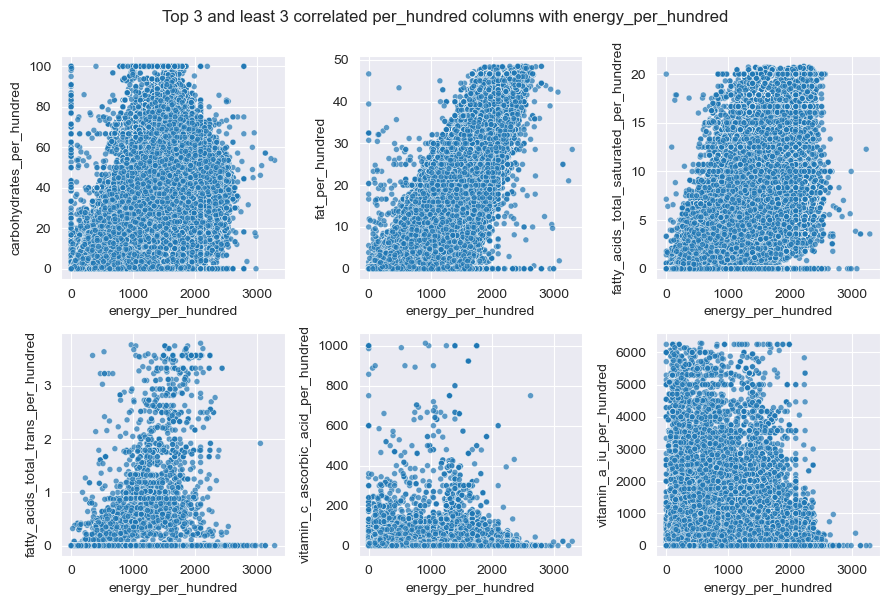

In [11]:
# Create a subplot with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
ax = ax.ravel()

# Iterate through the top_correlations_columns and plot a scatterplot
for i, column in enumerate(correlations_columns):
    sns.scatterplot(x=df['energy_per_hundred'],
                    y=df[column],
                    size=8,
                    alpha=0.7,
                    ax=ax[i])
    ax[i].legend_.remove()
    
plt.suptitle("Top 3 and least 3 correlated per_hundred columns with energy_per_hundred", y=1)
plt.tight_layout()
plt.show()

* Carbs, fat and fatty_acids_total_saturated are weak positive linear relationships. Scatter markers are clearly not following a line.
* On no correlation, we can see only maybe with vitamin_a could be some non linear weak or negative linear weak relationship. 

We use function robust=True of regplot, as documentation says that this "will de-weight outliers"

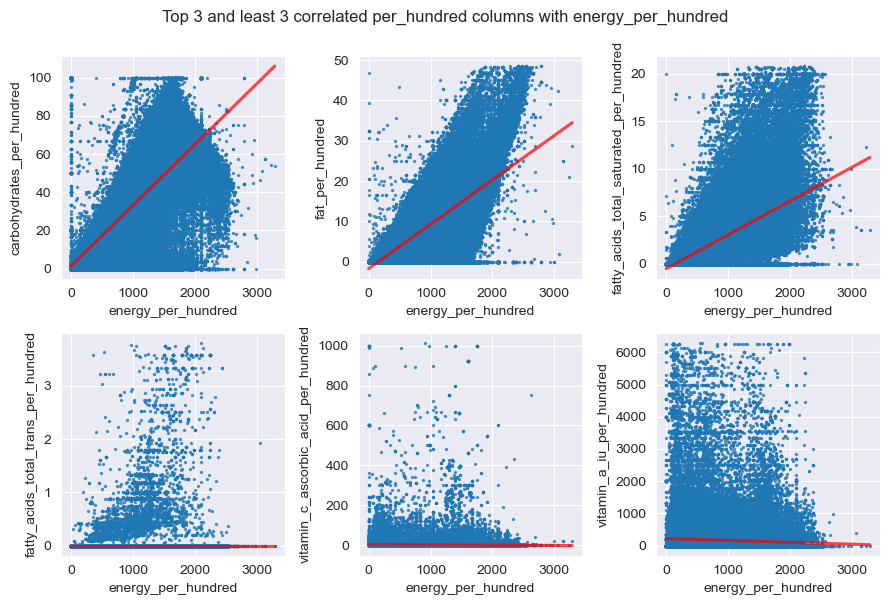

In [12]:
# Create a subplot with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
ax = ax.ravel()

# Iterate through the top_correlations_columns and plot a regplot
for i, column in enumerate(correlations_columns):
    sns.regplot(x=df['energy_per_hundred'],
                y=df[column],
                scatter=True,
                scatter_kws={'s':2,'alpha':0.7},
                ci=None,
                line_kws={'color':'r','alpha':0.7},
                robust=True,
                ax=ax[i])
    
plt.suptitle("Top 3 and least 3 correlated per_hundred columns with energy_per_hundred", y= 1)
plt.tight_layout()
plt.show()

We don't see a significative change in correlation a result, the weak correlations are still extremely weak.
There is even less correlation between energy and vitamin_a

## Independence
Your task is to test the independence of two categorical variables statistically. Use the energy_per_hundred column to create a new variable that holds equal proportion of values in three categories low energy, medium energy and high energy. Test if the level of energy in the product is associated with the country where the product is produced.

In [13]:
# Create 'energy_class' column
# Using the quantiles to define the limits for the three categories:
# low energy: 0-33%
# medium energy: 34-66%
# high energy: 67-100%
df_energy = df.copy()
df_energy['energy_class'] = pd.qcut(df_energy['energy_per_hundred'], q=[0, .33, .66, 1], labels=['low', 'medium', 'high'])

We use the Chi-square test of independence the objective is to test whether two categorical variables are independent or not. We use method described here https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/statistical-data-analysis-v4/units/hypothesis-testing-v4

The null hypothesis is that the energy_class and country are independent, while the alternative hypothesis is that they are not independent. The p-value is calculated by using the chi2_contingency function. We will compare it with a significance level of 0.05 to determine whether to reject or fail to reject the null hypothesis.

In [17]:
from scipy.stats import chi2_contingency

chi_square, p_value, dof, matrix = chi2_contingency(pd.crosstab(df_energy['energy_class'], df_energy['country']))
print(chi_square, p_value)

701.3778541472196 3.178182208136727e-144


In our case p value is 3.17e-144 is certainly less than our significance value of 0.05 therefore we can reject our hypothesis. Energy_class and country are not independent.